# DCGANで馬と鹿の分類を行う
CIFAR10のデータセットの中で特に馬と鹿を区別する問題を考える。
このノートでは実験として馬と鹿をDCGANによる学習で判定することを試みる。

この問題は本質的に光子と電子の識別問題を考えることと等価であると考えられるのでその思惑もある。

## 目標
* まず馬だけからなるデータセットを準備する。CIFAR10から、5000枚の画像データを準備することができる。ラベルは7である。
* 5000枚の馬のデータから、Fake馬を作成し、敵対生成ネットワークによる学習で`馬の判定機`を作成する
* 馬の判定機にCIFAR10の全画像を投げて、馬の認識制度を評価する

他にも可能性のある方法として（[GANの解説記事](https://www.imagazine.co.jp/gan%EF%BC%9A%E6%95%B5%E5%AF%BE%E7%9A%84%E7%94%9F%E6%88%90%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%A8%E3%81%AF%E4%BD%95%E3%81%8B%E3%80%80%EF%BD%9E%E3%80%8C%E6%95%99%E5%B8%AB/#:~:text=%E3%81%AA%E3%81%8B%E3%81%A7%E3%82%82%E6%9C%80%E8%BF%91%E6%B3%A8%E7%9B%AE%E3%81%95%E3%82%8C,%E3%81%AB%E6%B2%BF%E3%81%A3%E3%81%A6%E5%A4%89%E6%8F%9B%E3%81%A7%E3%81%8D%E3%82%8B%E3%80%82)）も参考になる。これによると、例えばフェイク画像を大量に作ってCNNの検出精度を高めるという方法もあるらしい。

## データセットの準備

In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import BatchSampler, SubsetRandomSampler,DataLoader
import torchvision.utils as vutils
from IPython.display import HTML

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2

In [46]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


In [47]:
target_class = [7]#馬

In [48]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

tmp_loader = DataLoader(trainset)
train_target = []

for i, data in enumerate(tmp_loader):
    _, label = data
    if(label.numpy().item() in target_class):
        train_target.append(i)

trainloader = DataLoader(trainset,num_workers=0, batch_sampler = BatchSampler(SubsetRandomSampler(train_target, generator=None), batch_size=batch_size, drop_last=True))

Files already downloaded and verified


In [49]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

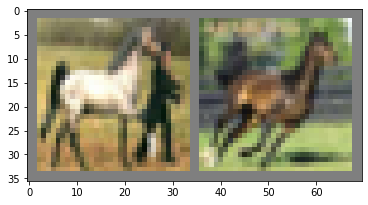

In [50]:
# get some random training images
dataiter = iter(trainloader)
images, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [51]:
dataiter.next()[0].size(0)

2

## DCGANのモデル構築

In [52]:
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [53]:
# Root directory for dataset
dataroot = "./data/"

# Number of training epochs
num_epochs = 5

# Number of workers for dataloader
workers = 0

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 4

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [54]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [55]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [56]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [57]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [58]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [59]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [60]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## 学習

In [61]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[1/5][0/2500]	Loss_D: 1.3771	Loss_G: 0.7054	D(x): 0.5055	D(G(z)): 0.5009 / 0.4939
[1/5][500/2500]	Loss_D: 0.0713	Loss_G: 3.2527	D(x): 0.9794	D(G(z)): 0.0491 / 0.0388
[1/5][1000/2500]	Loss_D: 1.0321	Loss_G: 0.8767	D(x): 0.7999	D(G(z)): 0.5468 / 0.4163
[1/5][1500/2500]	Loss_D: 0.7640	Loss_G: 1.0882	D(x): 0.7677	D(G(z)): 0.3833 / 0.3375
[1/5][2000/2500]	Loss_D: 1.1972	Loss_G: 1.1654	D(x): 0.5945	D(G(z)): 0.4903 / 0.3118
[2/5][0/2500]	Loss_D: 0.6294	Loss_G: 1.4739	D(x): 0.7315	D(G(z)): 0.2665 / 0.2306
[2/5][500/2500]	Loss_D: 2.7150	Loss_G: 2.7608	D(x): 0.8340	D(G(z)): 0.9016 / 0.0786
[2/5][1000/2500]	Loss_D: 0.6628	Loss_G: 1.8480	D(x): 0.7027	D(G(z)): 0.1920 / 0.1581
[2/5][1500/2500]	Loss_D: 1.2145	Loss_G: 1.3207	D(x): 0.5589	D(G(z)): 0.3707 / 0.2843
[2/5][2000/2500]	Loss_D: 0.8133	Loss_G: 1.4874	D(x): 0.6487	D(G(z)): 0.2151 / 0.2300
[3/5][0/2500]	Loss_D: 0.3537	Loss_G: 2.5289	D(x): 0.8761	D(G(z)): 0.1860 / 0.0913
[3/5][500/2500]	Loss_D: 1.2460	Loss_G: 2.4119	D(x)

## 結果の評価

### fake 画像の出力

In [62]:
torch.save(netD.state_dict(), './DCGAN_weight/dcgan_D.pth')
torch.save(netG.state_dict(), './DCGAN_weight/dcgan_G.pth')

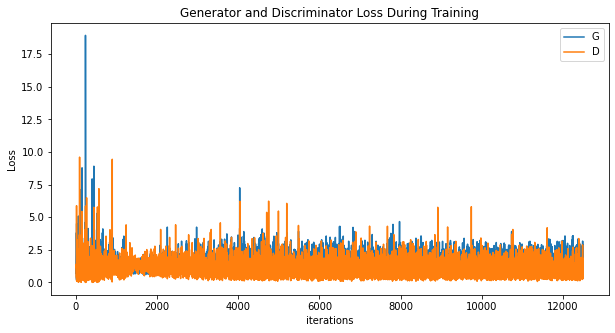

In [63]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

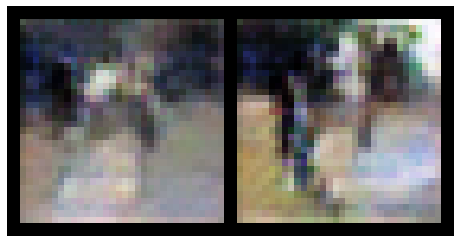

In [64]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

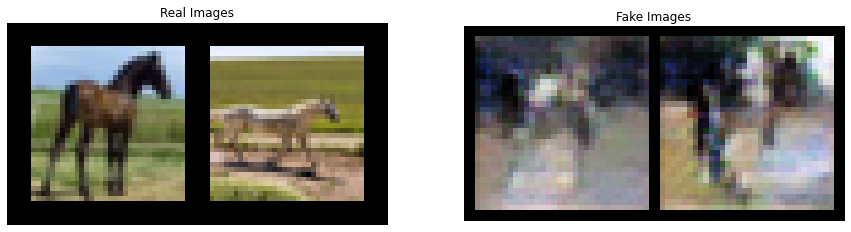

In [65]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [66]:
dataiter = iter(trainloader)
images, _ = dataiter.next()

In [67]:
images.numpy().shape

(2, 3, 32, 32)

In [68]:
real_cpu = images.to(device)
b_size = real_cpu.size(0)
print(b_size)
label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
print(label)

2
tensor([1., 1.], device='cuda:0')


In [69]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
print(noise.shape)

torch.Size([2, 100, 1, 1])


In [70]:
print(len(img_list[-1]))

3


In [71]:
print(len(img_list[-1][0]))

36


In [72]:
fake = netG(noise)

In [73]:
print(fake.shape)

torch.Size([2, 3, 32, 32])


### DiscriminatorでCIFAR10を再分類する

次のことを行う。
* CIFAR10のテストデータから馬の画像のセットを作成し、Discriminatorで分類する
* CIFAR10のテストデータから馬以外の画像のセットを作成し、Discriminatorで分類する

In [74]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


In [75]:
test_true_class = [7]#馬
test_false_class = [0,1,2,3,4,5,6,8,9]#馬以外

In [76]:
testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

tmp_loader = DataLoader(testset)
test_true_target = []
test_false_target = []

for i, data in enumerate(tmp_loader):
    _, label = data
    if(label.numpy().item() in test_true_class):
        test_true_target.append(i)
    else:
        test_false_target.append(i)

trueloader = DataLoader(testset,num_workers=0, batch_sampler = BatchSampler(test_true_target, batch_size=4, drop_last=True))
falseloader = DataLoader(testset,num_workers=0, batch_sampler = BatchSampler(test_false_target, batch_size=4, drop_last=True))

Files already downloaded and verified


In [77]:
netD = Discriminator(ngpu).to(device)
netD.load_state_dict(torch.load('./DCGAN_weight/dcgan_D.pth'))

<All keys matched successfully>

In [78]:
correct = 0
total = 0
with torch.no_grad():
    for data in trueloader:
        images = data[0].to(device)
        outputs = netD(images)
        predicted = outputs.squeeze().round()
        total += 4
        correct += (predicted == 1).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 72 %


In [79]:
correct = 0
total = 0
with torch.no_grad():
    for data in falseloader:
        images = data[0].to(device)
        outputs = netD(images)
        predicted = outputs.squeeze().round()
        total += 4
        correct += (predicted == 0).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [80]:
correct = 0
total = 0
with torch.no_grad():
    for data in trueloader:
        images = data[0].to(device)
        outputs = netD(images)

In [81]:
outputs.squeeze().round()

tensor([0., 1., 1., 1.], device='cuda:0')